In [28]:
from eval_gnn import eval_gnn
from str2env import str2env
import numpy as np
import torch
from time import time
from torch_geometric.data import Data
from config import set_random_seed
from tqdm import tqdm as tqdm
from torch_sparse import coalesce
from torch_geometric.nn import knn_graph

loop = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
def to_np(tensor):
    return tensor.data.cpu().numpy()

def to_tuple(array):
    return tuple(array.reshape(1, -1)[0])

def to_nparray(t):
    return np.array(t).reshape(1, -1)[0]

In [30]:
class DotDict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    
def obs_data(env, free, collided):
    data = DotDict({
        'free': torch.FloatTensor(np.array(free)).to(device),
        'collided': torch.FloatTensor(np.array(collided))[:len(free)].to(device),
        'obstacles': torch.FloatTensor(env.obstacles).to(device),
    })
    return data

In [31]:
# test on new environment
from config import set_random_seed
from str2name import str2name


from environment import MazeEnv
env = MazeEnv(dim=2, map_file='maze_files/mazes_new_dataset.npz')
indexes = range(0, 1000)
bs = 100  # only sample 100 points

env.init_new_problem(5)
set_random_seed(1234)
_, model, model_path, model_s, model_s_path = str2name(str(env))

# result = explore(env, model, model_s, smooth=True, smoother='model', batch=bs, t_max=bs, k=10)


In [32]:
'''
model: path explore to find a possible path
model_s: smooth model
loop: level of gnn
'''

batch=500
t_max=1000 
k=30
loop=5

c0 = env.collision_check_count
t0 = time()
forward = 0

success = False
path = []
n_batch = batch

print(type(n_batch))

free, collided = env.sample_n_points(n_batch, need_negative=True)
print("free 0:", free[0], "len:", len(free))
print("collided 0:", collided[0], "len", len(collided))


<class 'int'>
free 0: [-0.12454452  0.57071717] len: 500
collided 0: [-0.6169611   0.24421754] len 419


In [33]:
# collided len will same to free.
collided = collided[:len(free)]
free = [env.init_state] + [env.goal_state] + list(free)
print("free len:", len(free))
print("collided len", len(collided))

free len: 502
collided len 419


In [34]:
def create_data(free, collided, env, k):
    data = Data(goal=torch.FloatTensor(env.goal_state))
    
    # graph vertices start point + end point + free + collied
    data.v = torch.cat((torch.FloatTensor(np.array(free)),
                        torch.FloatTensor(np.array(collided))), dim=0)

    # create labels
    data.labels = torch.zeros(len(data.v), 3)
    #  the vertices in the free space
    data.labels[:len(free), 0] = 1
    #  the vertices with collision
    data.labels[len(free):, 1] = 1
    # goal vertex
    data.labels[1, 2] = 1
    k1 = int(np.ceil(k * np.log(len(free)) / np.log(100)))
    edge_index = knn_graph(torch.FloatTensor(data.v), k=k1, loop=True)
    edge_index = torch.cat((edge_index, edge_index.flip(0)), dim=-1)
    edge_index_free = knn_graph(torch.FloatTensor(data.v[:len(free)]), k=k1, loop=True)
    edge_index = torch.cat((edge_index, edge_index_free, edge_index_free.flip(0)), dim=-1)
    data.edge_index, _ = coalesce(edge_index, None, len(data.v), len(data.v))

    return data

In [35]:
explored = [0]
explored_edges = [[0, 0]]
costs = {0: 0.}
prev = {0: 0}
data = create_data(free, collided, env, k)

In [36]:
# random tree
# idea is explore from end to start point
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph()


# add point into graph (vertices is the explored points. explore from goal point)
node_start = to_tuple(env.init_state)
node_goal = None

# G.add_node(node_goal)
# check graph connection


In [37]:

node_start = to_tuple(to_np(data.v[0]))
print(node_start)

(-0.56962156, 0.6670727)


In [38]:
# data.edge_index = radius_graph(data.v, radius(len(data.v)), loop=True)

while not success and (len(free) - 2) <= t_max:

    t1 = time()
    policy = model(**data.to(device).to_dict(), **obs_data(env, free, collided), loop=loop)

    # print("-------policy------")
    # print(policy.size())
    # print("-------end policy------")
    
    policy = policy.cpu()
    forward += time() - t1

    policy[torch.arange(len(data.v)), torch.arange(len(data.v))] = 0
    policy[:, explored] = 0
    policy[:, data.labels[:, 1] == 1] = 0
    policy[data.labels[:, 1] == 1, :] = 0
    policy[np.array(explored_edges).reshape(2, -1)] = 0

    success = False

    while policy[explored, :].sum() != 0:
        # print(torch.where(policy[explored, :] != 0))
        agent = policy[
            np.array(explored)[torch.where(policy[explored, :] != 0)[0]], torch.where(policy[explored, :] != 0)[
                1]].argmax()
        # print("agent", agent)
        end_a, end_b = torch.where(policy[explored, :] != 0)[0][agent], torch.where(policy[explored, :] != 0)[1][
            agent]
        # print("{} --> {}".format(end_a, end_b))
        
        end_a, end_b = int(end_a), int(end_b)
        end_a = explored[end_a]
        explored_edges.extend([[end_a, end_b], [end_b, end_a]])
        
        state_a = to_np(data.v[end_a])
        state_b = to_np(data.v[end_b])

        if env._edge_fp(state_a, state_b):
            explored.append(end_b)
            costs[end_b] = costs[end_a] + np.linalg.norm(state_a - state_b)
            prev[end_b] = end_a

            # add edge to graph
            tmp_a = to_tuple(state_a)
            tmp_b = to_tuple(state_b)
            
            G.add_edge(tmp_a, tmp_b, weight=np.linalg.norm(state_a - state_b))
            
            policy[:, end_b] = 0
            if env.in_goal_region(state_b):
                node_goal = tmp_b
                success = True
                cost = costs[end_b]
                path = [end_b]
                node = end_b
                
                while node != 0:
                    path.append(prev[node])
                    node = prev[node]
                path.reverse()
                break
        else:
            policy[end_a, end_b] = 0
            policy[end_b, end_a] = 0

    if not success:
        print("no success")
        if (n_batch + len(free) - 2) > t_max:
            break
        # ----------------------------------------resample----------------------------------------
        new_free, new_collided = env.sample_n_points(n_batch, need_negative=True)
        free = free + list(new_free)
        collided = collided + list(new_collided)
        collided = collided[:len(free)]
        data = create_data(free, collided, env, k)
    else:
        path = list(data.v[path].data.cpu().numpy())

c_explore = env.collision_check_count - c0


In [39]:
print(path)

[array([-0.56962156,  0.6670727 ], dtype=float32), array([-0.34413868,  0.84129626], dtype=float32), array([-0.0639765,  0.5804555], dtype=float32), array([0.26297402, 0.5890698 ], dtype=float32), array([0.5523614, 0.564956 ], dtype=float32), array([0.79980224, 0.73445725], dtype=float32), array([0.8438067 , 0.74655217], dtype=float32), array([0.8635039, 0.6920494], dtype=float32), array([0.865654 , 0.6522901], dtype=float32), array([0.77938217, 0.6074988 ], dtype=float32), array([0.8116144, 0.5371665], dtype=float32), array([0.76354444, 0.52533555], dtype=float32), array([0.84589773, 0.4404828 ], dtype=float32), array([0.8035921, 0.4130563], dtype=float32), array([0.8216995, 0.3842735], dtype=float32), array([0.8625942 , 0.34632558], dtype=float32), array([0.8662802 , 0.30275628], dtype=float32), array([0.83639616, 0.25147334], dtype=float32), array([0.8163477 , 0.18923418], dtype=float32), array([0.7624284 , 0.14534517], dtype=float32), array([0.76667154, 0.13827716], dtype=float32),

In [40]:
# check graph search from node_start to node_goal


<Figure size 640x480 with 0 Axes>

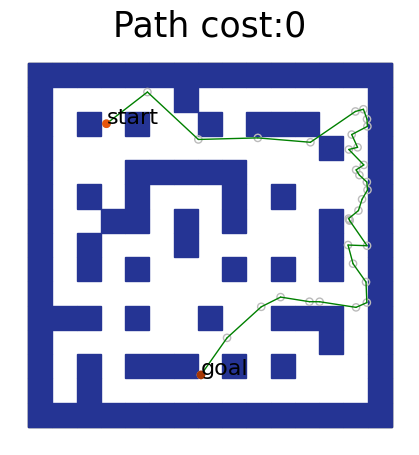

In [41]:
from utils.plot import plot_edges, plot_env_only, plot_optimization_edges
%matplotlib inline
import matplotlib.pyplot as plt
from utils.plot import plot_edges

edges = data.v[np.array(explored_edges).reshape(-1) ].reshape(-1, 2, 2)

edges = [[tuple(k), tuple(v)] for k, v in zip(edges[:, 0, :].cpu().numpy(), edges[:, 1, :].cpu().numpy())]
# distance = env.path_distance(path)
plot_optimization_edges(path, edges, env.get_problem(), \
           title='Path cost:{}'.format(0), \
           save=None)
plt.show()

In [42]:

nodes = list(G.nodes)
print(len(nodes))
print(len(explored))


(x, y) = list(G.edges)[0]
print(x, y)



292
292
(-0.56962156, 0.6670727) (-0.34413868, 0.84129626)


In [43]:
from utils.plot import draw_edge, draw_node
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_graph(G, problem, optim_path=[], fig=None, edge_classes=None, title='Figure', title_size=25):
    print(list(G.nodes)[0])

    nodes = [np.array(x) for x in list(G.nodes)]

    edges = [(np.array(x), np.array(y)) for (x, y) in list(G.edges)] 
    
    plt.clf()
    environment_map = problem["map"]
    init_state = problem["init_state"]
    goal_state = problem["goal_state"]
    dim = init_state.size

    if fig is None:
        fig = plt.figure(figsize=(4, 4))

    rect = patches.Rectangle((0.0, 0.0), 2.0, 2.0, linewidth=1, edgecolor='black', facecolor='none')
    plt.gca().add_patch(rect)

    map_width = environment_map.shape
    d_x = 2.0 / map_width[0]
    d_y = 2.0 / map_width[1]
    for i in range(map_width[0]):
        for j in range(map_width[1]):
            if environment_map[i, j] > 0:
                rect = patches.Rectangle((d_x * i, d_y * j), d_x, d_y, linewidth=1, edgecolor='#253494',
                                         facecolor='#253494')
                plt.gca().add_patch(rect)

    for i in range(len(nodes)):
        draw_node(nodes[i], '#bbbbbb', dim=dim)
        # plt.annotate('{}'.format(i), states[i]+1.0, color='black', fontsize=20)

    for i in range(len(edges)):
        draw_edge(edges[i][0], edges[i][1], 'green', dim=dim)
    
    if len(optim_path) > 1:
        for i in range(len(optim_path) - 1):
            draw_edge(np.array(optim_path[i]), np.array(optim_path[i+1]), 'red', dim=dim)
        
    draw_node(init_state, '#e6550d', dim=dim, face=True)
    draw_node(goal_state, '#a63603', dim=dim, face=True)
    
    plt.annotate('start', init_state+1.0, color='black', fontsize=16)
    plt.annotate('goal', goal_state+1.0, color='black', fontsize=16)

    plt.axis([0.0, 2.0, 0.0, 2.0])
    plt.axis('off')
    plt.axis('square')

    plt.subplots_adjust(left=-0., right=1.0, top=1.0, bottom=-0.)

    if title == '':
        plt.title('#%d Samples' % len(states) + ' #%d Edges' % len(edges), fontdict = {'fontsize':title_size})
    else:
        plt.title(title, fontdict = {'fontsize':title_size})

    # plt.show()

    return fig

(-0.56962156, 0.6670727)


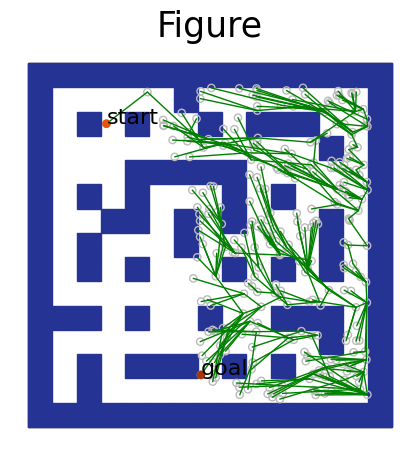

<Figure size 640x480 with 0 Axes>

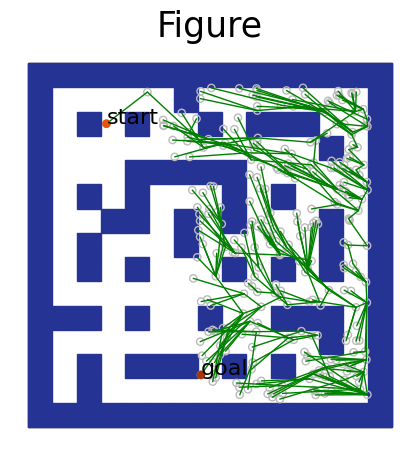

In [44]:
plot_graph(G, env.get_problem())

In [45]:
for node in G.nodes:
    G.nodes[node]['pos'] = node


True
True


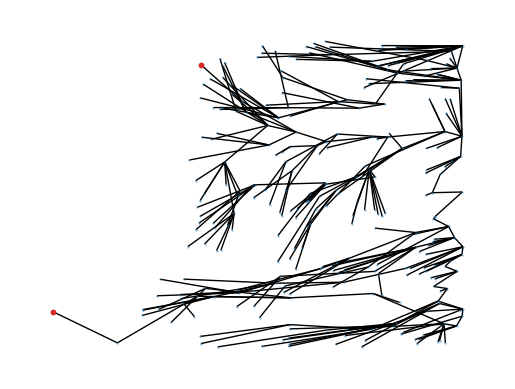

In [46]:
from matplotlib import pyplot
pyplot.gca().invert_yaxis()

nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size=0.1)
print(G.has_node(node_start))
print(G.has_node(node_goal))
nx.draw_networkx_nodes(G, nx.get_node_attributes(G, 'pos'), nodelist=[node_start, node_goal], node_color="tab:red", node_size=10)

In [47]:
optim_path = nx.shortest_path(G, source=node_start, target=node_goal, weight="weight")
print(optim_path)

[(-0.56962156, 0.6670727), (-0.34413868, 0.84129626), (-0.063976504, 0.5804555), (0.26297402, 0.5890698), (0.5523614, 0.564956), (0.79980224, 0.73445725), (0.8438067, 0.74655217), (0.8635039, 0.6920494), (0.865654, 0.6522901), (0.77938217, 0.6074988), (0.8116144, 0.5371665), (0.76354444, 0.52533555), (0.84589773, 0.4404828), (0.8035921, 0.4130563), (0.8216995, 0.3842735), (0.8625942, 0.34632558), (0.8662802, 0.30275628), (0.83639616, 0.25147334), (0.8163477, 0.18923418), (0.7624284, 0.14534517), (0.76667154, 0.13827716), (0.7680812, 0.13410884), (0.86397755, -0.0041417223), (0.7590522, -0.0001596716), (0.78670454, -0.10283196), (0.8581462, -0.2037468), (0.8626773, -0.31676286), (0.8031402, -0.34297213), (0.6028019, -0.31203783), (0.5470026, -0.3118), (0.38825533, -0.28654525), (0.28182563, -0.33998522), (0.0937615, -0.5107101), (-0.04982368, -0.7145029)]


(-0.56962156, 0.6670727)


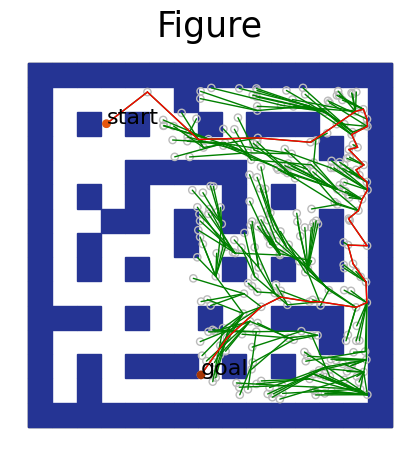

<Figure size 640x480 with 0 Axes>

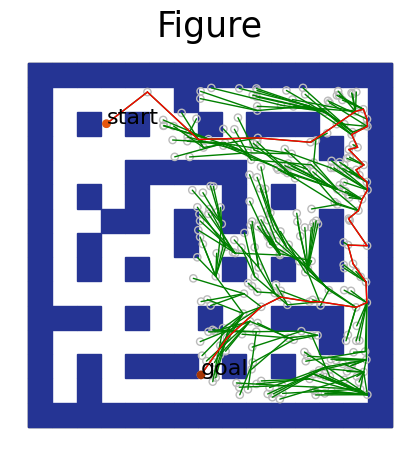

In [48]:
plot_graph(G, env.get_problem(), optim_path= optim_path)

In [55]:
from copy import deepcopy
graph = deepcopy(G)

number_nodes = len(graph.nodes)
nodes = list(graph.nodes)
count = 0
for i in range(number_nodes):
    collision = 0
    for j in range(i+1, number_nodes):
        node_x, node_y = nodes[i], nodes[j]
        if not graph.has_edge(node_x, node_y):
            if env._edge_fp(np.array(node_x), np.array(node_y)):
                graph.add_edge(node_x, node_y, weight=np.linalg.norm(np.array(node_x) - np.array(node_y)))
                count = count + 1
            else:
                collision = collision + 1

        # if collision > 100:
        #     break
print("add {} edges".format(count))

add 6988 edges


In [56]:
print(len(graph.nodes))
print(len(G.nodes))

292
292


In [57]:
optim_path = nx.shortest_path(graph, source=node_start, target=node_goal, weight="weight")
print(optim_path)

[(-0.56962156, 0.6670727), (-0.34413868, 0.84129626), (-0.063976504, 0.5804555), (0.4113764, 0.52805775), (0.30339673, 0.30893034), (0.18682265, -0.267851), (-0.04982368, -0.7145029)]


(-0.56962156, 0.6670727)


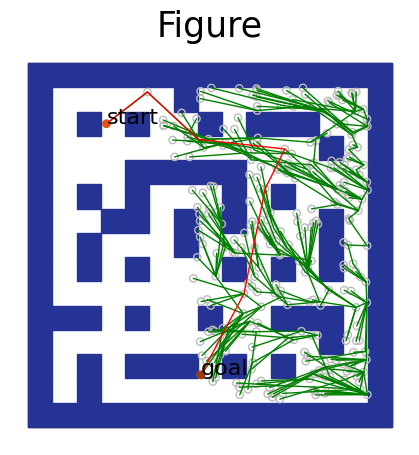

<Figure size 640x480 with 0 Axes>

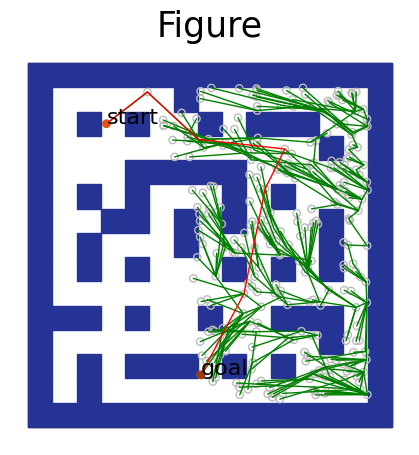

In [58]:
plot_graph(G, env.get_problem(), optim_path= optim_path)

In [53]:
print(graph.edges(node_start))
print(graph.edges(node_goal))

[((-0.56962156, 0.6670727), (-0.34413868, 0.84129626))]
[((-0.04982368, -0.7145029), (0.0937615, -0.5107101)), ((-0.04982368, -0.7145029), (0.02477612, -0.64632297)), ((-0.04982368, -0.7145029), (0.024855006, -0.71048707)), ((-0.04982368, -0.7145029), (0.031421598, -0.7294963)), ((-0.04982368, -0.7145029), (-0.019754022, -0.63861966)), ((-0.04982368, -0.7145029), (-0.05399411, -0.53161937)), ((-0.04982368, -0.7145029), (0.16375747, -0.8240226)), ((-0.04982368, -0.7145029), (-0.04381241, -0.6086497)), ((-0.04982368, -0.7145029), (0.16070607, -0.78219444)), ((-0.04982368, -0.7145029), (0.015148981, -0.75161797)), ((-0.04982368, -0.7145029), (-0.091777906, -0.18347535)), ((-0.04982368, -0.7145029), (0.1453185, -0.7586756))]


In [54]:
print(nx.shortest_path(graph, source=node_start, target=node_goal, weight="weight"))

[(-0.56962156, 0.6670727), (-0.34413868, 0.84129626), (-0.063976504, 0.5804555), (0.26297402, 0.5890698), (-0.008536574, 0.582284), (0.07341205, 0.54647744), (0.36692587, 0.42540404), (0.30339673, 0.30893034), (0.28616178, 0.08936747), (0.24592432, -0.17407466), (0.2096439, -0.21001425), (0.18682265, -0.267851), (0.10493788, -0.45391348), (0.05625422, -0.55346394), (-0.019754022, -0.63861966), (-0.04982368, -0.7145029)]
